# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'geometry/6/grenoble_2020-07-09_1939973.zip'
simgrid_archives = ['../smpi_hpl/geometry/18/grenoble_2020-07-09_1939976.zip']
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[250000]


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
#    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
        if len(tmp_trace) > nbrow_limit:
            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=250000)
# Mode: reality
	BLAS trace:  45784 lines (removed 0 lines with null sizes)
	MPI  trace:  64812 lines
Removed 31206 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace:  44379 lines (removed 181839 lines with null sizes)
	MPI  trace:  23070 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size
0,0.000000,4.103116,../HPL_pdtest.c,smpi_marker,NaN,BLAS,202.0,NaN,-1,NaN,0,4.103116,4.103116,reality,1,250000
1,0.000192,4.103359,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,250000.0,-1,NaN,0,4.103167,4.103167,reality,1,250000
2,0.000014,4.103377,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,-1,NaN,0,4.103363,4.103363,reality,1,250000
3,0.000003,4.103382,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,-1,NaN,0,4.103379,4.103379,reality,1,250000
4,0.000182,4.103570,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,249999.0,-1,NaN,0,4.103388,4.103388,reality,1,250000


## HPL result

In [4]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,56.81


In [5]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,30.96


## Checking the parameters

In [6]:
parameters = read_csv(simgrid_archives[0], 'exp_hpl.csv')
for archive in simgrid_archives:
    assert read_csv(archive, 'exp_hpl.csv').equals(parameters)
parameters

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [7]:
read_csv(reality_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [8]:
platforms = set([zipfile.ZipFile(archive).read('dahu.xml').decode('ascii') for archive in simgrid_archives])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460

In [9]:
from IPython.display import display, Markdown
for archive in simgrid_archives:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    installfile_content = zipfile.ZipFile(archive).read(installfile).decode()
    display(Markdown('Archive name: %s' % archive))
    display(Markdown('```yaml\n%s\n```' % installfile_content))

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Archive name: ../smpi_hpl/geometry/18/grenoble_2020-07-09_1939976.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

## Visualizing the trace

In [10]:
traces['func'] = traces['function']
traces.loc[~traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

In [11]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = False
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

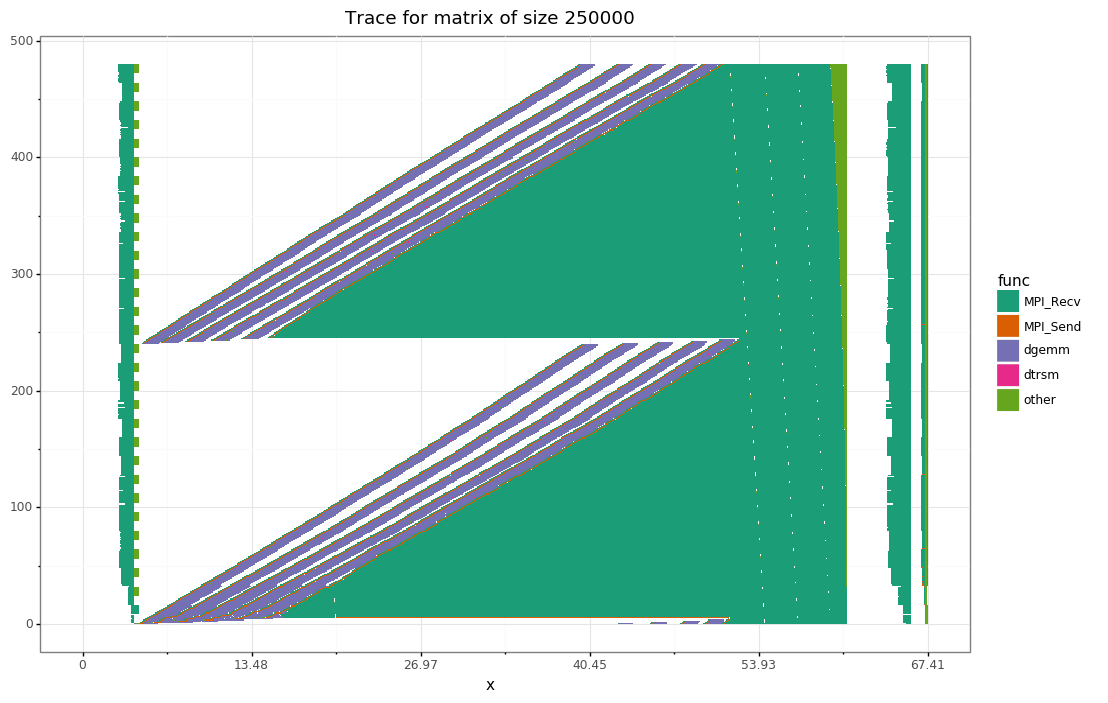

<ggplot: (-9223363244891023637)>


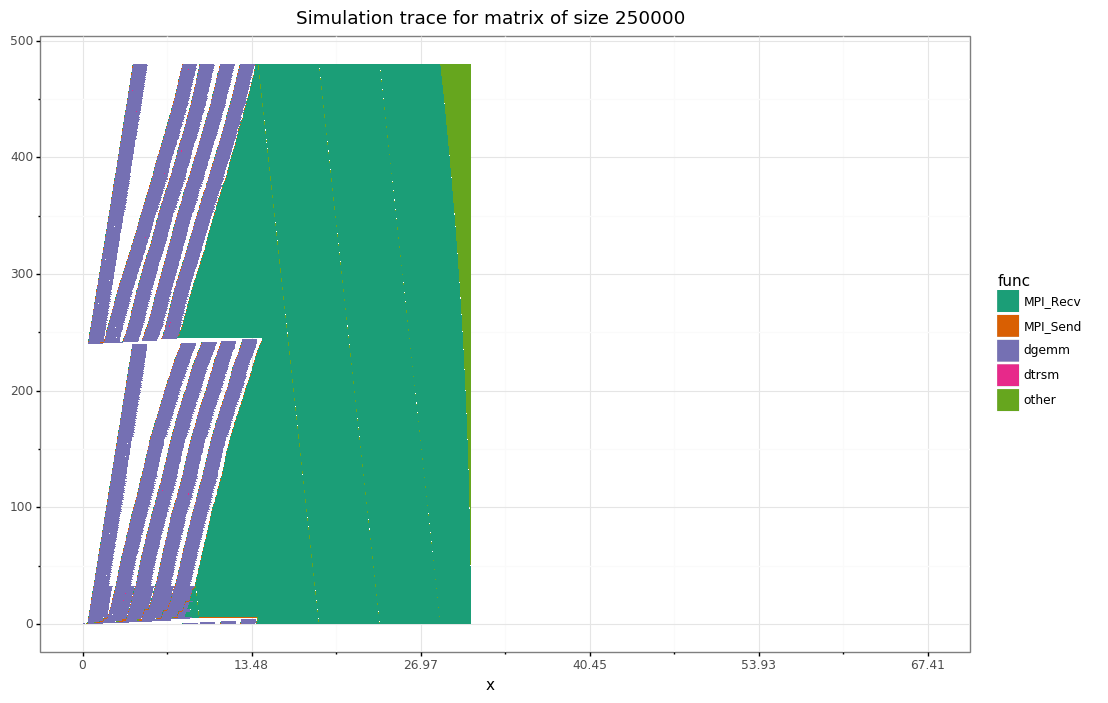

<ggplot: (8791962998543)>


In [12]:
for size in sorted(traces.matrix_size.unique()):
    tmp = traces[(traces['matrix_size'] == size)]
    lines = my_range(tmp.start.min(), tmp.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    print(plot(tmp[tmp['mode'] != 'reality'], lines=lines) + ggtitle('Simulation trace for matrix of size %d' % size))

In [13]:
min_croped = traces[(traces['mode'] == 'reality') & (traces['function'] == 'smpi_marker')].timestamp.min()
max_croped = traces[(traces['mode'] == 'reality') & (traces['function'] == 'smpi_marker')].timestamp.max()
print(min_croped, max_croped)
tmp_simg = traces[(traces['mode'] == 'simgrid')]
tmp_real = traces[(traces['mode'] == 'reality') & (traces['start'] > min_croped) & (traces['end'] < max_croped)].copy()
tmp_real['start'] -= min_croped
tmp_real['end'] -= min_croped
traces_croped = pandas.concat([tmp_real, tmp_simg]).reset_index(drop=True)

4.103072 60.911840000000005


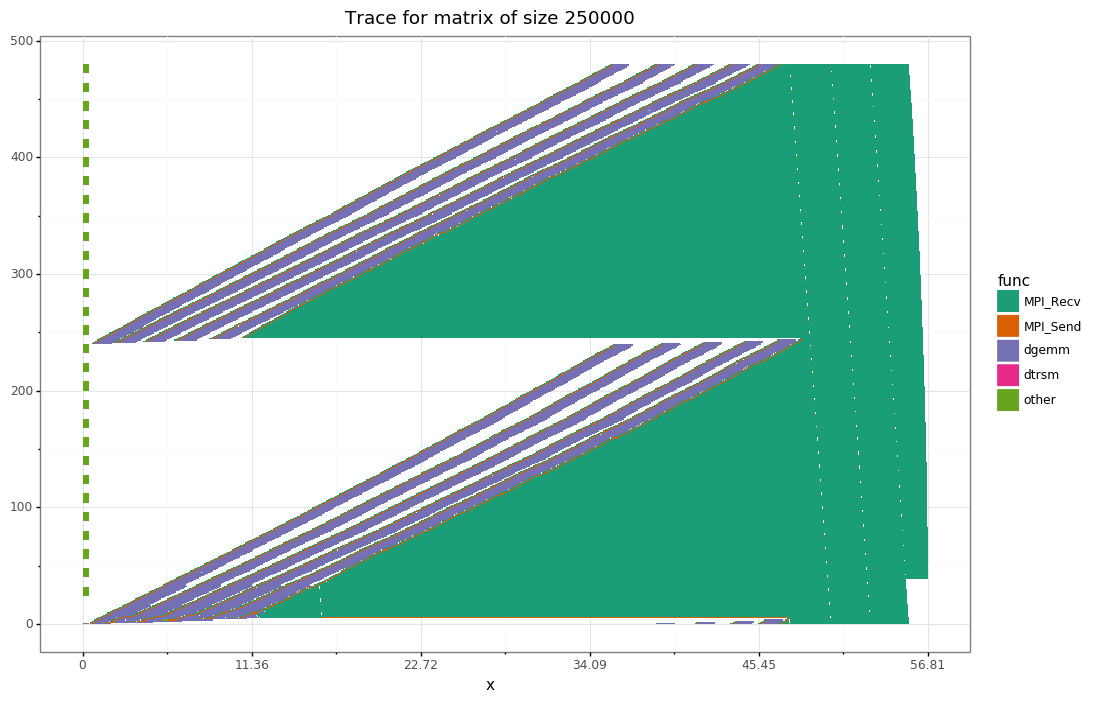

<ggplot: (-9223363244936158176)>


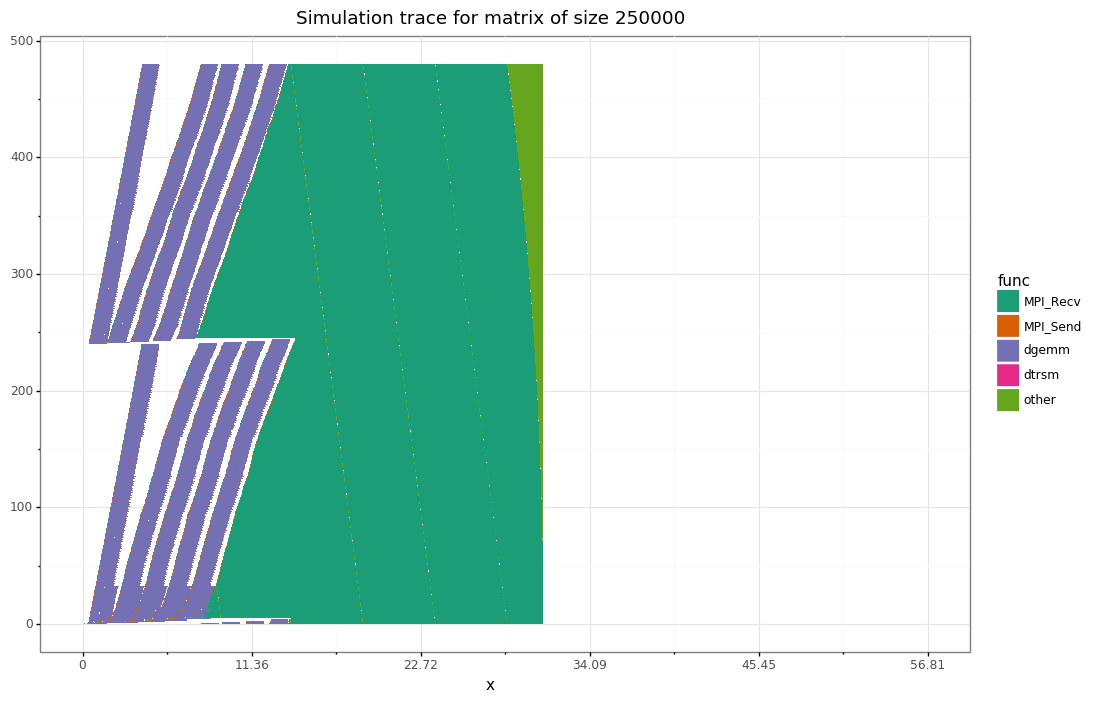

<ggplot: (8791929843909)>


In [14]:
for size in sorted(traces_croped.matrix_size.unique()):
    tmp = traces_croped[(traces_croped['matrix_size'] == size)]
    lines = my_range(traces_croped.start.min(), traces_croped.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    print(plot(tmp[tmp['mode'] != 'reality'], lines=lines) + ggtitle('Simulation trace for matrix of size %d' % size))

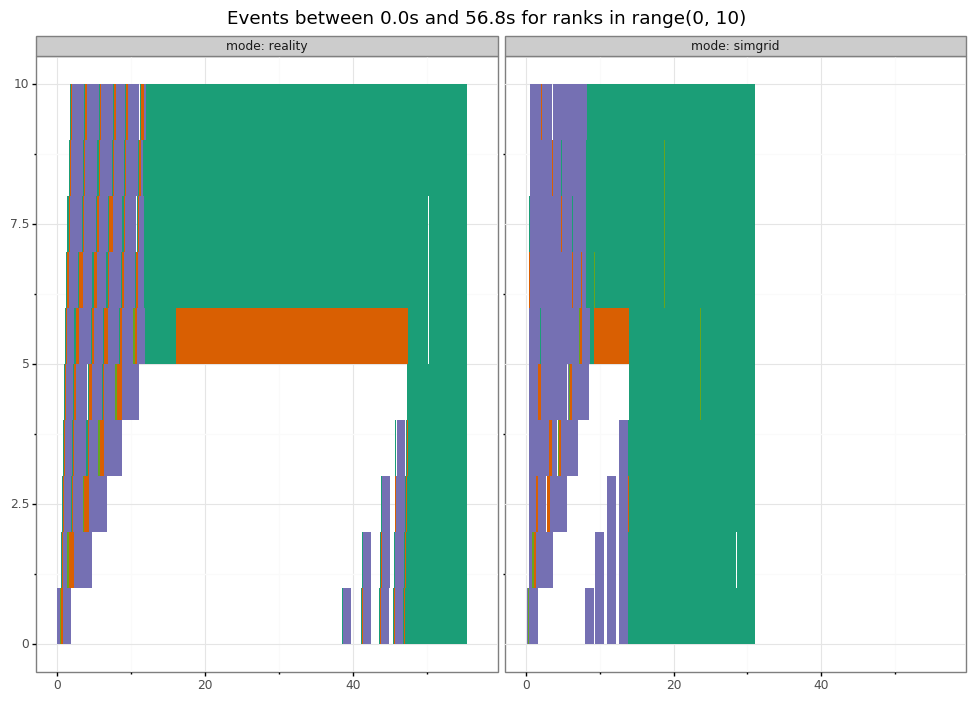

<ggplot: (-9223363244925322517)>

In [15]:
plot_bounded(traces_croped, 0, traces_croped.end.max(), range(10), wrap=['mode'])

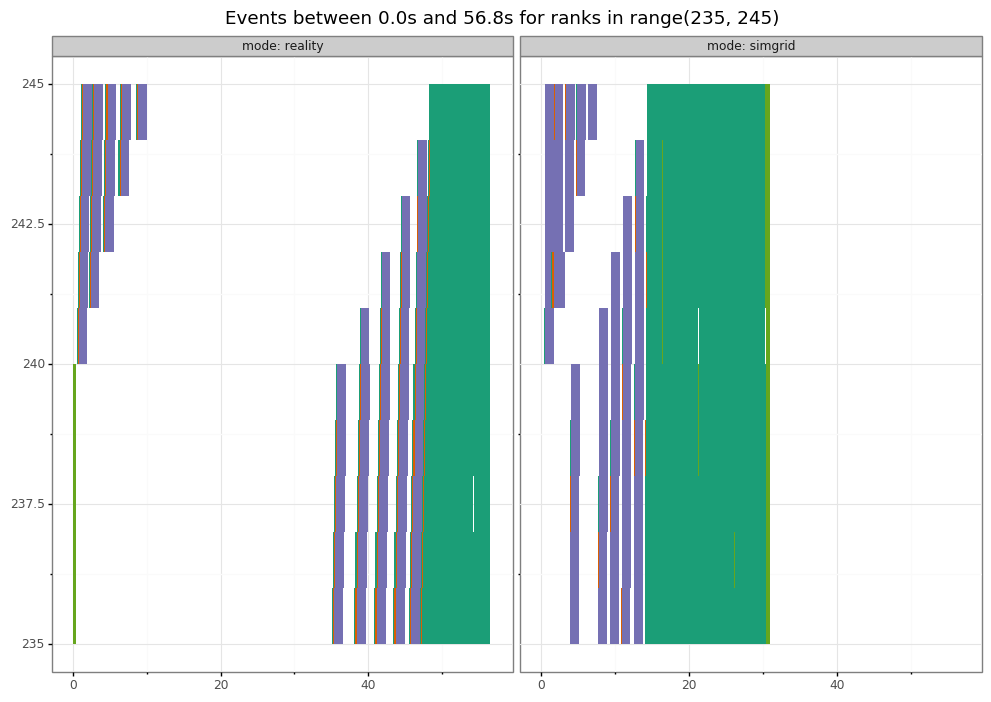

<ggplot: (8791962519581)>

In [16]:
plot_bounded(traces_croped, 0, traces_croped.end.max(), range(235, 245), wrap=['mode'])

Let's have a look at this `MPI_Send` from rank 5. First, is it a single call to the function, or several? What is the message size?

In [17]:
traces_croped[(traces_croped['rank'] == 5) & (traces_croped['start'] > 15) & (traces_croped['end'] < 48) & (traces_croped['mode'] == 'reality')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,file,line,start,end,function,rank,duration,msg_size
40692,../HPL_pdtrsv.c,248.0,16.048428,16.048514,daxpy,5,0.000086,-1
40693,../HPL_pdtrsv.c,257.0,16.048518,16.048556,dtrsv,5,0.000038,-1
40694,../HPL_pdtrsv.c,258.0,16.048558,16.048562,dcopy,5,0.000004,-1
40695,../HPL_pdtrsv.c,226.0,16.048558,16.054229,dgemv,5,0.005671,-1
45536,NaN,NaN,16.070807,47.475687,MPI_Send,5,31.404880,490496
40696,../HPL_pdtrsv.c,265.0,47.459118,47.475756,dgemv,5,0.016638,-1


In [18]:
evt = traces_croped[(traces_croped['rank'] == 5) & (traces_croped['start'] > 16) & (traces_croped['start'] < 17) & (traces_croped['mode'] == 'reality') & (traces_croped['function'] == 'MPI_Send')]
assert len(evt) == 1
evt_start = evt.iloc[0].start
evt_end = evt.iloc[0].end
evt_size = evt.iloc[0].msg_size
print(evt_start, evt_end, evt_size)
evt

16.070807 47.47568700000001 490496


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size,func
45536,31.40488,47.475687,NaN,MPI_Send,NaN,MPI,NaN,NaN,490496,NaN,5,16.070807,NaN,reality,6,250000,MPI_Send


Ok, this is a single call with a message of about 490kB and a duration of 31 seconds. This is very probably **not** a network issue, but rather the receiver which has a huge delay before receiving the message. Let's try to find out who is the likely culprit. We cannot be too tight on the time bounds, as the clocks of the nodes are not perfectly synchronized.

Let's add an extremly conservative bound on the duration (considering that this MPI_Recv should not block, as the corresponding MPI_Send was done a while ago).

In [19]:
duration_bound = evt_size / 1e6 + 0.1  # bandwidth of at least 1MB/s and latency of at most 0.1s
duration_bound

0.590496

In [20]:
traces_croped[(traces_croped['start'] > evt_end-1.5) &   # the MPI_Recv probably started at most 1s before the MPI_Send terminated
              (traces_croped['start'] < evt_end+0.5) &     # the MPI_Recv cannot start after the MPI_Send has terminated
              (traces_croped['end'] < evt_end+2) &     # the MPI_Recv cannot terminate too much after the MPI_Send
              (traces_croped['mode'] == 'reality') & (traces_croped['function'] == 'MPI_Recv') & # quite obvious
              (traces_croped['msg_size'] == evt_size) & # the message size must be the same
              (traces_croped['duration'] < duration_bound)
      ].sort_values(by='start')[['start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,start,end,function,rank,duration,msg_size
45601,46.957345,47.499266,MPI_Recv,479,0.541921,490496
54862,47.098543,47.499869,MPI_Recv,0,0.401326,490496
54833,47.224587,47.493684,MPI_Recv,1,0.269097,490496
52395,47.350397,47.487573,MPI_Recv,2,0.137176,490496
49961,47.475384,47.481534,MPI_Recv,3,0.006150,490496
47534,47.475402,47.475687,MPI_Recv,4,0.000285,490496


Now, let's try the same thing with the simulated data. Here the clocks **are** synchronized, so we can be much tighter. Hopefully the communication pattern will be exactly the same (this might not be true, since there is some randomness in HPL).

In [21]:
traces_croped[(traces_croped['rank'] == 5) & (traces_croped['start'] > 8) & (traces_croped['end'] < 14) & (traces_croped['mode'] == 'simgrid')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,file,line,start,end,function,rank,duration,msg_size
101280,NaN,NaN,8.706026,9.270327,MPI_Recv,5,5.643010e-01,490496
95592,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,248.0,9.267533,9.267533,daxpy,5,3.930000e-07,-1
95593,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,257.0,9.267533,9.267552,dtrsv,5,1.900500e-05,-1
95594,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,258.0,9.267552,9.267552,dcopy,5,1.000000e-08,-1
95595,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,226.0,9.267552,9.277575,dgemv,5,1.002341e-02,-1
101281,NaN,NaN,9.280370,13.936667,MPI_Send,5,4.656297e+00,490496
95596,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,265.0,13.933870,13.963662,dgemv,5,2.979243e-02,-1


In [22]:
evt = traces_croped[(traces_croped['rank'] == 5) & (traces_croped['start'] > 9.2) & (traces_croped['start'] < 10) & (traces_croped['mode'] == 'simgrid') & (traces_croped['function'] == 'MPI_Send')]
assert len(evt) == 1
evt_start = evt.iloc[0].start
evt_end = evt.iloc[0].end
evt_size = evt.iloc[0].msg_size
print(evt_start, evt_end, evt_size)
evt

9.28037 13.936667000000002 490496


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size,func
101281,4.656297,13.936667,NaN,MPI_Send,NaN,MPI,NaN,NaN,490496,NaN,5,9.28037,NaN,simgrid,6,250000,MPI_Send


In [23]:
traces_croped[(traces_croped['start'] > evt_end-1.5) &   # the MPI_Recv probably started at most 1s before the MPI_Send terminated
              (traces_croped['start'] <= evt_end+0.5) &      # the MPI_Recv cannot start after the MPI_Send has terminated
              (traces_croped['end'] < evt_end+2) &       # the MPI_Recv cannot terminate too much after the MPI_Send
              (traces_croped['mode'] == 'simgrid') & (traces_croped['function'] == 'MPI_Recv') & # quite obvious
              (traces_croped['msg_size'] == evt_size) & # the message size must be the same
              (traces_croped['duration'] < duration_bound)
             ].sort_values(by='start')[['start', 'end', 'function', 'rank', 'duration', 'msg_size']]

,start,end,function,rank,duration,msg_size
102544,13.550328,14.117655,MPI_Recv,466,0.567327,490496
102500,13.569947,14.107577,MPI_Recv,467,0.537630,490496
102462,13.594155,14.097553,MPI_Recv,468,0.503398,490496
102362,13.627540,14.087596,MPI_Recv,469,0.460056,490496
102326,13.650456,14.077611,MPI_Recv,470,0.427155,490496
102282,13.675053,14.067669,MPI_Recv,471,0.392616,490496
102242,13.691706,14.057642,MPI_Recv,472,0.365936,490496
102178,13.707571,14.047651,MPI_Recv,473,0.340080,490496
102142,13.725251,14.037639,MPI_Recv,474,0.312388,490496
102098,13.753424,14.027568,MPI_Recv,475,0.274144,490496


In both case, the most likely corresponding call to `MPI_Recv` is done by a rank in {0,1,2,3,4}. Looking at the Gantt chart, the rank 4 is even more suspicious as it has **no** reported activity before this `MPI_Recv` (the other four ranks have a long "idle" period, but they perform some calls to `dgemm` just before).

Now the question is, what is this idle period? What the hell is happening on this rank?

In [24]:
traces_croped[(traces_croped['rank'] == 4) & (traces_croped['start'] > 9.56) & (traces_croped['end'] < 48) & (traces_croped['mode'] == 'reality')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size', 'm', 'n', 'k']]

,file,line,start,end,function,rank,duration,msg_size,m,n,k
38973,NaN,0.0,9.822318,9.822829,HPL_dlaswp00N,4,0.000511,-1,128.0,128.0,NaN
38974,../HPL_pdupdateTT.c,184.0,9.822838,9.823043,dtrsm,4,0.000205,-1,128.0,128.0,NaN
38975,../HPL_pdupdateTT.c,202.0,9.823048,10.140956,dgemm,4,0.317908,-1,249360.0,128.0,128.0
38976,NaN,0.0,10.140968,10.141482,HPL_dlaswp00N,4,0.000514,-1,128.0,128.0,NaN
38977,../HPL_pdupdateTT.c,184.0,10.141488,10.141679,dtrsm,4,0.000191,-1,128.0,128.0,NaN
38978,../HPL_pdupdateTT.c,202.0,10.141678,10.457608,dgemm,4,0.315930,-1,249360.0,128.0,128.0
38979,NaN,0.0,10.457618,10.458146,HPL_dlaswp00N,4,0.000528,-1,128.0,128.0,NaN
38980,../HPL_pdupdateTT.c,184.0,10.458148,10.458345,dtrsm,4,0.000197,-1,128.0,128.0,NaN
38981,../HPL_pdupdateTT.c,202.0,10.458358,10.765239,dgemm,4,0.306881,-1,249360.0,128.0,128.0
38982,NaN,0.0,10.765248,10.765756,HPL_dlaswp00N,4,0.000508,-1,128.0,128.0,NaN


In [25]:
traces_croped[(traces_croped['rank'] == 4) & (traces_croped['start'] > 7.83) & (traces_croped['end'] < 14) & (traces_croped['mode'] == 'simgrid')].sort_values(by='start')[['file', 'line', 'start', 'end', 'function', 'rank', 'duration', 'msg_size', 'm', 'n', 'k']]

,file,line,start,end,function,rank,duration,msg_size,m,n,k
93861,NaN,0.0,8.004278,8.004278,HPL_dlaswp00N,4,1.000000e-08,-1,128.0,128.0,NaN
93862,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,184.0,8.004278,8.004387,dtrsm,4,1.087390e-04,-1,128.0,128.0,NaN
93863,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,8.004387,8.305469,dgemm,4,3.010825e-01,-1,249360.0,128.0,128.0
93864,NaN,0.0,8.305472,8.305472,HPL_dlaswp00N,4,1.000000e-08,-1,128.0,128.0,NaN
93865,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,184.0,8.305472,8.305585,dtrsm,4,1.126300e-04,-1,128.0,128.0,NaN
93866,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,8.305585,8.600238,dgemm,4,2.946525e-01,-1,249360.0,128.0,128.0
101770,NaN,NaN,13.922270,13.936629,MPI_Recv,4,1.435900e-02,255345672,NaN,NaN,NaN
93867,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,248.0,13.933870,13.933870,daxpy,4,1.000000e-08,-1,61312.0,NaN,NaN
93868,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,257.0,13.933870,13.933890,dtrsv,4,1.960300e-05,-1,128.0,NaN,NaN
93869,/tmp/hpl-2.2/src/pgesv/HPL_pdtrsv.c,258.0,13.933890,13.933890,dcopy,4,1.000000e-08,-1,128.0,NaN,NaN


So, both in reality and in simulation, this rank does:
- a few very short BLAS functions in `HPL_pdupdateTT`
- an extremly long blank period
- a large call to `MPI_Recv` (with a ~255MB buffer)
- a few very short BLAS functions in `HPL_pdtrsv`
- the call to `MPI_Recv` which (probably) un-block the very long `MPI_Send` posted by rank 5